# Energy Evaluation

### Define Energy Intesities

In [17]:
TRACE_RETENTION_HOURS = 360 # 30 days

# energy intensity kWh/GB
ENERGY_INTENSITY_NETWORK_KWH_PER_GB = 0.001875
ENERGY_INTENSITY_STORAGE_WH_PER_TB_HOUR = 0.525 * TRACE_RETENTION_HOURS

## Load pre-processed data
This data can be pre-processed with the help of kepler-evaluation.ipynb (CPU+RAM), network-evaluation.ipynb and storage-evaluation.ipynb. If you want to do new experiments, you have to create these files yourself in the meantioned jupyter notebooks.

In [18]:
import pandas as pd
import tabulate as tabulate
network_data = pd.read_csv("cadvisor_network_bytes_received_all_absolute_bytes.csv", index_col=0)
network_data_transmitted = pd.read_csv("cadvisor_network_bytes_transmitted_all_absolute_bytes.csv", index_col=0)
storage_data = pd.read_csv("cadvisor_storage_usage_writes_all_absolute_bytes.csv", index_col=0)
kepler_data_joules = pd.read_csv("pods_kepler_joules_all_absolute_joules.csv", index_col=0)
kepler_dram = pd.read_csv("pods_kepler_dram_joules_all_joules.csv", index_col=0)


## Network
Further process the network data to transform total bytes received to kWh using the energy intensity

In [19]:
# get the last value for each label based on the time_normalized_rounded as this is the total amount of data received
network_data_processed = network_data.groupby("label").last().reset_index()


# remove the column time_normalized_rounded as it is not needed anymore
network_data_processed = network_data_processed.drop(columns=["time_normalized_rounded"])

# remove _system-under-evaluation from the column names
network_data_processed.columns = network_data_processed.columns.str.replace("_system-under-evaluation", "", regex=False)

network_data_processed = network_data_processed.set_index("label")

network_data_processed = network_data_processed.reindex([
    "Baseline",
    "0%",
    "5%",
    "10%",
    "50%",
    "1s",
    "30s",
    "Base Persistence",
    "Scrape 5s Persistence",
    "5% Persistence",
    "10% Persistence",
    "50% Persistence",
    "Persistence Istio",
])

# drop indexes the experiments that are not needed e.g. Baseline, 0%, 5%, 10%, 50%, 1s, 30s
network_data_processed = network_data_processed.drop(index=[
    "Baseline",
    "0%",
    "5%",
    "10%",
    "50%",
    "1s",
    "30s",
])

# rename the columns to be more readable
network_data_processed = network_data_processed.rename(index={
    "Base Persistence": "Baseline",
    "Scrape 5s Persistence": "Scrape 5s",
    "5% Persistence": "5%",
    "10% Persistence": "10%",
    "50% Persistence": "50%",
    "Persistence Istio": "Istio",
})



# this values are in bytes, convert them to GB
network_data_processed = network_data_processed / (1000 * 1000 * 1000)


print("Total network data received per Experiment (label) in GB:")
print(network_data_processed.round(2).to_markdown())


# calculate the energy consumption in kWh
network_data_processed = network_data_processed * ENERGY_INTENSITY_NETWORK_KWH_PER_GB


# print as table
print("Total network data received per Experiment (label) and energy consumption in kWh:")
print(network_data_processed.to_markdown())
print("Total energy consumption for storage in kWh per Experiment (label) and percentage difference from label 'Baseline':")

for label in network_data_processed.index:
    if label == "Baseline":
        print(f"{label}: {network_data_processed.loc[label].sum()} kWh (100%)")
    else:
        percentage_difference = (network_data_processed.loc[label].sum() / network_data_processed.loc["Baseline"].sum()) * 100
        print(f"{label}: {network_data_processed.loc[label].sum()} kWh ({percentage_difference:.2f}%)")

Total network data received per Experiment (label) in GB:
| label     |   accounting |   ad |   cart |   checkout |   currency |   elasticsearch |   email |   flagd |   fraud-detection |   frontend |   frontend-proxy |   grafana |   image-provider |   jaeger-collector |   jaeger-query |   kafka |   otel-collector |   payment |   product-catalog |   prometheus |   quote |   recommendation |   shipping |   valkey-cart |
|:----------|-------------:|-----:|-------:|-----------:|-----------:|----------------:|--------:|--------:|------------------:|-----------:|-----------------:|----------:|-----------------:|-------------------:|---------------:|--------:|-----------------:|----------:|------------------:|-------------:|--------:|-----------------:|-----------:|--------------:|
| Baseline  |            0 | 0.04 |   0.15 |          0 |          0 |            0.32 |       0 |    0.03 |                 0 |       1.42 |             1.59 |         0 |                0 |               0.04 |  

In [20]:
# get the last value for each label based on the time_normalized_rounded as this is the total amount of data received
network_data_transmitted_processed = network_data_transmitted.groupby("label").last().reset_index()


# remove the column time_normalized_rounded as it is not needed anymore
network_data_transmitted_processed = network_data_transmitted_processed.drop(columns=["time_normalized_rounded"])

# remove _system-under-evaluation from the column names
network_data_transmitted_processed.columns = network_data_transmitted_processed.columns.str.replace("_system-under-evaluation", "", regex=False)

network_data_transmitted_processed = network_data_transmitted_processed.set_index("label")

network_data_transmitted_processed = network_data_transmitted_processed.reindex([
    "Baseline",
    "0%",
    "5%",
    "10%",
    "50%",
    "1s",
    "30s",
    "Base Persistence",
    "Scrape 5s Persistence",
    "5% Persistence",
    "10% Persistence",
    "50% Persistence",
    "Persistence Istio"
])

# drop indexes the experiments that are not needed e.g. Baseline, 0%, 5%, 10%, 50%, 1s, 30s
network_data_transmitted_processed = network_data_transmitted_processed.drop(index=[
    "Baseline",
    "0%",
    "5%",
    "10%",
    "50%",
    "1s",
    "30s",
])

# rename the columns to be more readable
network_data_transmitted_processed = network_data_transmitted_processed.rename(index={
    "Base Persistence": "Baseline",
    "Scrape 5s Persistence": "Scrape 5s",
    "5% Persistence": "5%",
    "10% Persistence": "10%",
    "50% Persistence": "50%",
    "Persistence Istio": "Istio",
})


# this values are in bytes, convert them to GB
network_data_transmitted_processed = network_data_transmitted_processed / (1000 * 1000 * 1000)


print("Total network data transmitted per Experiment (label) in GB:")
print(network_data_transmitted_processed.round(2).to_markdown())


# calculate the energy consumption in kWh
network_data_transmitted_processed = network_data_transmitted_processed * ENERGY_INTENSITY_NETWORK_KWH_PER_GB


# print as table
print("Total network data transmitted per Experiment (label) and energy consumption in kWh:")
print(network_data_transmitted_processed.to_markdown())
print("Total energy consumption for storage in kWh per Experiment (label) and percentage difference from label 'Baseline':")

for label in network_data_transmitted_processed.index:
    if label == "Baseline":
        print(f"{label}: {network_data_transmitted_processed.loc[label].sum()} kWh (100%)")
    else:
        percentage_difference = (network_data_transmitted_processed.loc[label].sum() / network_data_transmitted_processed.loc["Baseline"].sum()) * 100
        print(f"{label}: {network_data_transmitted_processed.loc[label].sum()} kWh ({percentage_difference:.2f}%)")

Total network data transmitted per Experiment (label) in GB:
| label     |   accounting |   ad |   cart |   checkout |   currency |   elasticsearch |   email |   flagd |   fraud-detection |   frontend |   frontend-proxy |   grafana |   image-provider |   jaeger-collector |   jaeger-query |   kafka |   otel-collector |   payment |   product-catalog |   prometheus |   quote |   recommendation |   shipping |   valkey-cart |
|:----------|-------------:|-----:|-------:|-----------:|-----------:|----------------:|--------:|--------:|------------------:|-----------:|-----------------:|----------:|-----------------:|-------------------:|---------------:|--------:|-----------------:|----------:|------------------:|-------------:|--------:|-----------------:|-----------:|--------------:|
| Baseline  |         0    | 0.26 |   0.66 |       0    |       0    |            0.01 |    0    |    0.09 |              0    |       3.35 |             3.74 |      0    |             0    |               0.33 

## Storage
Further process the storage data to transform total bytes used to kWh using the energy intensity

In [21]:
storage_data_processed = storage_data.groupby("label").last().reset_index()

# remove the column time_normalized_rounded as it is not needed anymore
storage_data_processed = storage_data_processed.drop(columns=["time_normalized_rounded"])

# remove _system-under-evaluation from the column names
storage_data_processed.columns = storage_data_processed.columns.str.replace("_system-under-evaluation", "", regex=False)

storage_data_processed = storage_data_processed.set_index("label")

# sort the index for readability in this order: Baseline, 5%, 10%, 50%, Baseline Persistence, 5% Persistence, 10% Persistence, 50% Persistence
storage_data_processed = storage_data_processed.reindex([
    "Baseline",
    "0%",
    "5%",
    "10%",
    "50%",
    "1s",
    "30s",
    "Base Persistence",
    "Scrape 5s Persistence",
    "5% Persistence",
    "10% Persistence",
    "50% Persistence",
    "Persistence Istio",
])

# drop indexes the experiments that are not needed e.g. Baseline, 0%, 5%, 10%, 50%, 1s, 30s
storage_data_processed = storage_data_processed.drop(index=[
    "Baseline",
    "0%",
    "5%",
    "10%",
    "50%",
    "1s",
    "30s",
])

# rename the columns to be more readable
storage_data_processed = storage_data_processed.rename(index={
    "Base Persistence": "Baseline",
    "Scrape 5s Persistence": "Scrape 5s",
    "5% Persistence": "5%",
    "10% Persistence": "10%",
    "50% Persistence": "50%",
    "Persistence Istio": "Istio",
})

# rename opentelemetry-collector to otel-collector
storage_data_processed = storage_data_processed.rename(index={"opentelemetry-collector": "otel-collector"})


# this values are in bytes, convert them to TB
storage_data_processed = storage_data_processed / (1000 * 1000 * 1000 * 1000)



print("Storage data used per Experiment (label) in GB:")
print(storage_data_processed.multiply(1000).to_markdown())

# calculate the energy consumption in kWh
storage_data_processed = (storage_data_processed * ENERGY_INTENSITY_STORAGE_WH_PER_TB_HOUR) / 1000




# print as table
print("Total energy consumption for storage in kWh per Experiment (label):")
print(storage_data_processed.to_markdown())
print("Total energy consumption for storage in kWh per Experiment (label) and percentage difference from label 'Baseline':")

for label in storage_data_processed.index:
    if label == "Baseline":
        print(f"{label}: {storage_data_processed.loc[label].sum()} kWh (100%)")
    else:
        percentage_difference = (storage_data_processed.loc[label].sum() / storage_data_processed.loc["Baseline"].sum()) * 100
        print(f"{label}: {storage_data_processed.loc[label].sum()} kWh ({percentage_difference:.2f}%)")


Storage data used per Experiment (label) in GB:
| label     |   accounting |         ad |   elasticsearch |   email |   flagd |   fraud-detection |   frontend |   frontend-proxy |     grafana |   image-provider |     kafka |   opensearch |   opentelemetry-collector |   payment |   prometheus |   recommendation |   valkey-cart |
|:----------|-------------:|-----------:|----------------:|--------:|--------:|------------------:|-----------:|-----------------:|------------:|-----------------:|----------:|-------------:|--------------------------:|----------:|-------------:|-----------------:|--------------:|
| Baseline  |            0 | 0.00636518 |         2.63411 |       0 |       0 |         0.0194314 |          0 |                0 | 0.000425984 |                0 | 0.095191  |     10.7099  |                       nan |         0 |    0.0915661 |                0 |   0.000172032 |
| Scrape 5s |            0 | 0.020906   |         2.75934 |       0 |       0 |         0.0194888 |       

Further process the CPU energy data. We use the average over the experiment as the kWh

In [22]:
""" kepler_data_processed = kepler_data.groupby("label").mean()

# remove the column time_normalized_rounded as it is not needed anymore
kepler_data_processed = kepler_data_processed.drop(columns=["time_normalized_rounded"])

# remove _system-under-evaluation from the column names
kepler_data_processed.columns = kepler_data_processed.columns.str.replace("_Auxiliary-under-evaluation", "", regex=False)

# sort the index for readability in this order: Baseline, 5%, 10%, 50%, Baseline Persistence, 5% Persistence, 10% Persistence, 50% Persistence
kepler_data_processed = kepler_data_processed.reindex([
    "Baseline",
    "0%",
    "5%",
    "10%",
    "50%",
    "1s",
    "Base Persistence",
    "5% Persistence",
    "10% Persistence",
    "50% Persistence",
    "Base Persistence Istio"
])

# print as table
print("Total energy consumption in kWh per Experiment (label):")
print(kepler_data_processed.to_markdown())
print("Total energy consumption in kWh per Experiment (label) and percentage difference from label 'Baseline':")

for label in kepler_data_processed.index:
    if label == "Baseline":
        print(f"{label}: {kepler_data_processed.loc[label].sum()} kWh (100%)")
    else:
        percentage_difference = (kepler_data_processed.loc[label].sum() / kepler_data_processed.loc["Baseline"].sum()) * 100
        print(f"{label}: {kepler_data_processed.loc[label].sum()} kWh ({percentage_difference:.2f}%)") """

' kepler_data_processed = kepler_data.groupby("label").mean()\n\n# remove the column time_normalized_rounded as it is not needed anymore\nkepler_data_processed = kepler_data_processed.drop(columns=["time_normalized_rounded"])\n\n# remove _system-under-evaluation from the column names\nkepler_data_processed.columns = kepler_data_processed.columns.str.replace("_Auxiliary-under-evaluation", "", regex=False)\n\n# sort the index for readability in this order: Baseline, 5%, 10%, 50%, Baseline Persistence, 5% Persistence, 10% Persistence, 50% Persistence\nkepler_data_processed = kepler_data_processed.reindex([\n    "Baseline",\n    "0%",\n    "5%",\n    "10%",\n    "50%",\n    "1s",\n    "Base Persistence",\n    "5% Persistence",\n    "10% Persistence",\n    "50% Persistence",\n    "Base Persistence Istio"\n])\n\n# print as table\nprint("Total energy consumption in kWh per Experiment (label):")\nprint(kepler_data_processed.to_markdown())\nprint("Total energy consumption in kWh per Experiment 

In [23]:
kepler_data_joules_processed = kepler_data_joules.groupby("label").last()

# remove the column time_normalized_rounded as it is not needed anymore
kepler_data_joules_processed = kepler_data_joules_processed.drop(columns=["time_normalized_rounded"])

# remove _system-under-evaluation from the column names
kepler_data_joules_processed.columns = kepler_data_joules_processed.columns.str.replace("_system-under-evaluation", "", regex=False)

# drop the columns that are not needed
kepler_data_joules_processed = kepler_data_joules_processed.drop(columns=["master", "worker"])


# sort the index for readability in this order: Baseline, 5%, 10%, 50%, Baseline Persistence, 5% Persistence, 10% Persistence, 50% Persistence
kepler_data_joules_processed = kepler_data_joules_processed.reindex([
    "Baseline",
    "0%",
    "5%",
    "10%",
    "50%",
    "1s",
    "30s",
    "Base Persistence",
    "Scrape 5s Persistence",
    "5% Persistence",
    "10% Persistence",
    "50% Persistence",
    "Persistence Istio",
])  

# drop indexes the experiments that are not needed e.g. Baseline, 0%, 5%, 10%, 50%, 1s, 30s
kepler_data_joules_processed = kepler_data_joules_processed.drop(index=[
    "Baseline",
    "0%",
    "5%",
    "10%",
    "50%",
    "1s",
    "30s",
])

# rename the columns to be more readable
kepler_data_joules_processed = kepler_data_joules_processed.rename(index={
    "Base Persistence": "Baseline",
    "Scrape 5s Persistence": "Scrape 5s",
    "5% Persistence": "5%",
    "10% Persistence": "10%",
    "50% Persistence": "50%",
    "Persistence Istio": "Istio",
})

kepler_data_joules_processed_total = kepler_data_joules_processed.copy()
kepler_data_joules_processed_total["Total"] = kepler_data_joules_processed.sum(axis=1)

# print as table
print("Total energy consumption in Joules per Experiment (label):")
print(kepler_data_joules_processed_total.to_markdown())

# convert Joules to kWh
kepler_data_joules_processed = kepler_data_joules_processed / 3600000  # 1 kWh = 3.6 million Joules
print("Total energy consumption in kWh per Experiment (label) and percentage difference from label 'Baseline':")

for label in kepler_data_joules_processed.index:
    if label == "Baseline":
        print(f"{label}: {kepler_data_joules_processed.loc[label].sum()} kWh (100%)")
    else:
        percentage_difference = (kepler_data_joules_processed.loc[label].sum() / kepler_data_joules_processed.loc["Baseline"].sum()) * 100
        print(f"{label}: {kepler_data_joules_processed.loc[label].sum()} kWh ({percentage_difference:.2f}%)")


Total energy consumption in Joules per Experiment (label):
| label     |   accounting |      ad |    cart |   checkout |   configfile |   currency |   elasticsearch |   email |   exporter |    flagd |   flagd-ui |   fraud-detection |   frontend |   frontend-proxy |   grafana |   image-provider |   init-config |   istio-init |   istio-proxy |   jaeger-agent-sidecar |   jaeger-collector |   jaeger-query |   kafka |   opensearch |   opentelemetry-collector |   payment |   product-catalog |   prometheus-server |   quote |   recommendation |   shipping |   valkey-cart |   wait-for-kafka |   wait-for-valkey-cart |   Total |
|:----------|-------------:|--------:|--------:|-----------:|-------------:|-----------:|----------------:|--------:|-----------:|---------:|-----------:|------------------:|-----------:|-----------------:|----------:|-----------------:|--------------:|-------------:|--------------:|-----------------------:|-------------------:|---------------:|--------:|-------------:|--

# DRAM
Does not work as expected currently. Values are strange and mostly negativ.


In [24]:
kepler_ram_joules_processed = kepler_dram.groupby("label").last()

# remove the column time_normalized_rounded as it is not needed anymore
kepler_ram_joules_processed = kepler_ram_joules_processed.drop(columns=["time_normalized_rounded"])

# remove _system-under-evaluation from the column names
kepler_ram_joules_processed.columns = kepler_ram_joules_processed.columns.str.replace("_system-under-evaluation", "", regex=False)

# sort the index for readability in this order: Baseline, 5%, 10%, 50%, Baseline Persistence, 5% Persistence, 10% Persistence, 50% Persistence
kepler_ram_joules_processed = kepler_ram_joules_processed.reindex([
    "Baseline",
    "0%",
    "5%",
    "10%",
    "50%",
    "1s",
    "30s",
    "Base Persistence",
    "Scrape 5s Persistence",
    "5% Persistence",
    "10% Persistence",
    "50% Persistence",
    "Persistence Istio",
])  


# drop indexes the experiments that are not needed e.g. Baseline, 0%, 5%, 10%, 50%, 1s, 30s
kepler_ram_joules_processed = kepler_ram_joules_processed.drop(index=[
    "Baseline",
    "0%",
    "5%",
    "10%",
    "50%",
    "1s",
    "30s",
])

# rename the columns to be more readable
kepler_ram_joules_processed = kepler_ram_joules_processed.rename(index={
    "Base Persistence": "Baseline",
    "Scrape 5s Persistence": "Scrape 5s",
    "5% Persistence": "5%",
    "10% Persistence": "10%",
    "50% Persistence": "50%",
    "Persistence Istio": "Istio",
})

kepler_ram_joules_processed_total = kepler_ram_joules_processed.copy()
kepler_ram_joules_processed_total["Total"] = kepler_ram_joules_processed.sum(axis=1)

# print as table
print("DRAM energy consumption in Joules per Experiment (label):")
print(kepler_ram_joules_processed_total.to_markdown())

# convert Joules to kWh
kepler_ram_joules_processed = kepler_ram_joules_processed / 3600000  # 1 kWh = 3.6 million Joules
print("Total energy consumption in kWh per Experiment (label) and percentage difference from label 'Baseline':")

for label in kepler_ram_joules_processed.index:
    if label == "Baseline":
        print(f"{label}: {kepler_ram_joules_processed.loc[label].sum()} kWh (100%)")
    else:
        percentage_difference = (kepler_ram_joules_processed.loc[label].sum() / kepler_ram_joules_processed.loc["Baseline"].sum()) * 100
        print(f"{label}: {kepler_ram_joules_processed.loc[label].sum()} kWh ({percentage_difference:.2f}%)")


DRAM energy consumption in Joules per Experiment (label):
| label     |   accounting |       ad |     cart |   checkout |   configfile |   currency |   elasticsearch |   email |     exporter |    flagd |   flagd-ui |   fraud-detection |   frontend |   frontend-proxy |   grafana |   image-provider |   init-config |   istio-init |   istio-proxy |   jaeger-agent-sidecar |   jaeger-collector |   jaeger-query |    kafka |   master |   opensearch |   opentelemetry-collector |   payment |   product-catalog |   prometheus-server |   quote |   recommendation |   shipping |   valkey-cart |   wait-for-kafka |   wait-for-valkey-cart |   worker |    Total |
|:----------|-------------:|---------:|---------:|-----------:|-------------:|-----------:|----------------:|--------:|-------------:|---------:|-----------:|------------------:|-----------:|-----------------:|----------:|-----------------:|--------------:|-------------:|--------------:|-----------------------:|-------------------:|-------------

Categorize the energy consumption into "App", "Auxiliary" and "System"

In [25]:
# | label            |   accounting |      ad |    cart |   checkout |   configfile |   copy-default-plugins |   currency |   elasticsearch |   elasticsearch-checker |   email |   flagd |   flagd-ui |   fraud-detection |   frontend |   frontend-proxy |   grafana |   image-provider |   init-config |   jaeger |   jaeger-agent-sidecar |   jaeger-collector |   jaeger-query |   kafka |   master |   opensearch |   opentelemetry-collector |   payment |   product-catalog |   prometheus-server |   quote |   recommendation |   shipping |   sysctl |   valkey-cart |   wait-for-kafka |   wait-for-valkey-cart |   worker |

kepler_mapping = {
    "accounting": "Primary",
    "ad": "Primary",
    "cart": "Primary",
    "checkout": "Primary",
    "configfile": "Primary",
    "copy-default-plugins": "Primary",
    "currency": "Primary",
    "elasticsearch": "Auxiliary",
    "elasticsearch-checker": "Auxiliary",
    "email": "Primary",
    "exporter": "Auxiliary",
    "flagd": "Auxiliary",
    "flagd-ui": "Auxiliary",
    "fraud-detection": "Primary",
    "frontend": "Primary",
    "frontend-proxy": "Primary",
    "grafana": "Auxiliary",
    "image-provider": "Primary",
    "init-config": "Primary",
    "istio-init": "Auxiliary",
    "istio-proxy": "Auxiliary",
    "jaeger": "Auxiliary",
    "jaeger-agent-sidecar": "Auxiliary",
    "jaeger-collector": "Auxiliary",
    "jaeger-query": "Auxiliary",
    "kafka": "Primary",
    "master": "Primary",
    "opensearch": "Auxiliary",
    "opentelemetry-collector": "Auxiliary",
    "payment": "Primary",
    "product-catalog": "Primary",
    "prometheus-server": "Auxiliary",
    "quote": "Primary",
    "recommendation": "Primary",
    "shipping": "Primary",
    "sysctl": "Auxiliary",
    "valkey-cart": "Primary",
    "wait-for-kafka": "Primary",
    "wait-for-valkey-cart": "Primary",
    "worker": "Primary",
}

#| label            |   accounting |          ad |   elasticsearch |   email |   flagd |   fraud-detection |     frontend |   frontend-proxy |     grafana |   image-provider |       kafka |   opensearch |   payment |   prometheus |   recommendation |   shipping |   valkey-cart |

storage_data_mapping = {
    "accounting": "Primary",
    "ad": "Primary",
    "elasticsearch": "Auxiliary",
    "email": "Primary",
    "flagd": "Auxiliary",
    "fraud-detection": "Primary",
    "frontend": "Primary",
    "frontend-proxy": "Primary",
    "grafana": "Auxiliary",
    "image-provider": "Primary",
    "kafka": "Primary",
    "opensearch": "Auxiliary",
    "payment": "Primary",
    "prometheus": "Auxiliary",
    "recommendation": "Primary",
    "shipping": "Primary",
    "valkey-cart": "Primary",
    "quote": "Primary",
    "product-catalog": "Primary",
    "opentelemetry-collector": "Auxiliary",
    "checkout": "Primary",
    "cart": "Primary",
    "jaeger": "Auxiliary",
    "currency": "Primary",
}

# | label            |   accounting |          ad |        cart |    checkout |    currency |   elasticsearch |   email |       flagd |   fraud-detection |   frontend |   frontend-proxy |     grafana |   image-provider |      jaeger |       kafka |   opensearch |   opentelemetry-collector |     payment |   product-catalog |   prometheus |   quote |   recommendation |   shipping |   valkey-cart |

network_data_mapping = {
    "accounting": "Primary",
    "ad": "Primary",
    "cart": "Primary",
    "checkout": "Primary",
    "currency": "Primary",
    "elasticsearch": "Auxiliary",
    "email": "Primary",
    "flagd": "Auxiliary",
    "fraud-detection": "Primary",
    "frontend": "Primary",
    "frontend-proxy": "Primary",
    "grafana": "Auxiliary",
    "image-provider": "Primary",
    "jaeger": "Auxiliary",
    "jaeger-collector": "Auxiliary", 
    "jaeger-query": "Auxiliary", 
    "otel-collector": "Auxiliary", 
    "kafka": "Primary",
    "opensearch": "Auxiliary",
    "opentelemetry-collector": "Auxiliary",
    "payment": "Primary",
    "product-catalog": "Primary",
    "prometheus": "Auxiliary",
    "quote": "Primary",
    "recommendation": "Primary",
    "shipping": "Primary",
    "valkey-cart": "Primary",
}


import pandas as pd

def categorize_energy_consumption(data: pd.DataFrame, mapping: dict) -> pd.DataFrame:
    """
    Categorize and sum energy consumption based on component categories.

    Parameters:
    - data (pd.DataFrame): A DataFrame where rows represent measurements and columns represent component labels.
    - mapping (dict): A mapping from component label (column name) to a category (e.g., "Primary", "Auxiliary").

    Returns:
    - pd.DataFrame: A DataFrame with the same row indices as `data` and columns being the summed energy per category,
                    including an 'Uncategorized' column if needed.
    """
    # Initialize a DataFrame to store summed results
    categorized = pd.DataFrame(index=data.index)

    # Identify columns that are in the mapping
    mapped_cols = set(mapping.keys())
    data_cols = set(data.columns)
    unmapped_cols = list(data_cols - mapped_cols)

    # Print warning for unmapped columns
    if unmapped_cols:
        print(f"[WARNING] Uncategorized columns: {unmapped_cols}")

    # Iterate through unique categories
    for category in set(mapping.values()):
        cols = [col for col in data.columns if mapping.get(col) == category]
        categorized[category] = data[cols].sum(axis=1) if cols else 0

    # Add uncategorized columns
    if unmapped_cols:
        categorized["Uncategorized"] = data[unmapped_cols].sum(axis=1)
    
    return categorized


# Categorize the energy consumption for each dataset
network_categorized = categorize_energy_consumption(network_data_processed, network_data_mapping)
storage_categorized = categorize_energy_consumption(storage_data_processed, storage_data_mapping)
kepler_categorized = categorize_energy_consumption(kepler_data_joules_processed, kepler_mapping)

# Print the categorized energy consumption
print("\nNetwork Energy Consumption Categorized:")
print(network_categorized.to_markdown())
print("\nStorage Energy Consumption Categorized:")
print(storage_categorized.to_markdown())
print("\nKepler Energy Consumption Categorized:")
print(kepler_categorized.to_markdown())

# add a suffix to each set of columns
net = network_categorized.add_suffix(" (Network)")
cpu = kepler_categorized.add_suffix(" (CPU+Mem)")
sto = storage_categorized.add_suffix(" (Storage)")

categorized_combined_suffix = pd.concat([net, cpu, sto], axis=1) * 1000
categorized_combined_suffix = categorized_combined_suffix.sort_index(axis=1)

# Compute total energy consumption per row
categorized_combined_suffix["Total"] = categorized_combined_suffix.sum(axis=1)

# Calculate percentage change from the "Baseline" row
baseline_total = categorized_combined_suffix.loc["Baseline", "Total"]
categorized_combined_suffix["Total Change (%)"] = (
    (categorized_combined_suffix["Total"] - baseline_total) / baseline_total * 100
).round(2)

print("\nCombined Categorized Energy Consumption by origin in Wh:")
print(categorized_combined_suffix.round(2).to_markdown())

# merge the categorized dataframes and sum on same column name
categorized_combined = pd.concat([network_categorized, storage_categorized, kepler_categorized], axis=1)
categorized_combined = categorized_combined.T.groupby(categorized_combined.columns).sum().T


# Print the combined categorized energy consumption
#print("\nCombined Categorized Energy Consumption:")
#print(categorized_combined.to_markdown())

# add total summing up the categories for each experiment (label)
categorized_combined["Total"] = categorized_combined.sum(axis=1)

#categorized_combined_transpose = categorized_combined.transpose()
#print(categorized_combined_transpose.to_markdown())

categorized_combined_transpose_wh = categorized_combined.T.copy() * 1000  # convert kWh to Wh

print("\nCombined Categorized Energy Consumption in Wh:")
print(categorized_combined_transpose_wh.round(2).to_markdown())

# Combine all three sources on service/component label level
combined_per_label = pd.concat([
    network_data_processed,
    storage_data_processed,
    kepler_data_joules_processed
], axis=1)

# Group by column name (i.e., per service/component), and sum if duplicate columns exist
combined_per_label = combined_per_label.groupby(combined_per_label.columns, axis=1).sum()

combined_per_label["Total"] = combined_per_label.sum(axis=1)

combined_per_label_wh = combined_per_label * 1000  # convert kWh to Wh

print("\nCombined Total Energy Consumption per Service (Wh):")
print(combined_per_label_wh.round(2).to_markdown())


combined_per_label_wh_T = combined_per_label_wh.T  # transposed: services as rows
combined_per_label_wh_T["Total"] = combined_per_label_wh_T.sum(axis=1)

print("\nTransposed: Total Energy per Service across all Experiments (Wh):")
print(combined_per_label_wh_T.round(2).to_markdown())






Network Energy Consumption Categorized:
| label     |    Primary |   Auxiliary |
|:----------|-----------:|------------:|
| Baseline  | 0.00846966 |   0.0116133 |
| Scrape 5s | 0.00845372 |   0.0138522 |
| 5%        | 0.00843779 |   0.0139451 |
| 10%       | 0.00847025 |   0.0170727 |
| 50%       | 0.00846904 |   0.040845  |
| Istio     | 0.00886953 |   0.0118434 |

Storage Energy Consumption Categorized:
| label     |     Primary |   Auxiliary |
|:----------|------------:|------------:|
| Baseline  | 2.28992e-05 |  0.00253941 |
| Scrape 5s | 2.53749e-05 |  0.00275594 |
| 5%        | 2.48616e-05 |  0.00355496 |
| 10%       | 2.63906e-05 |  0.00458665 |
| 50%       | 2.64177e-05 |  0.0144145  |
| Istio     | 2.47711e-05 |  0.00216078 |

Kepler Energy Consumption Categorized:
| label     |   Primary |   Auxiliary |
|:----------|----------:|------------:|
| Baseline  | 0.0583792 |   0.0110529 |
| Scrape 5s | 0.0567845 |   0.0121712 |
| 5%        | 0.0580523 |   0.012683  |
| 10%       | 

/tmp/ipykernel_2577407/214425870.py:207: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_per_label = combined_per_label.groupby(combined_per_label.columns, axis=1).sum()


# Latex Tables for the Paper

In [26]:
latex_categorized_combined_suffix = categorized_combined_suffix.round(2).copy()


# order columns 
latex_categorized_combined_suffix = latex_categorized_combined_suffix.reindex(
    columns=[
        "Primary (CPU+Mem)",
        "Primary (Network)",
        "Primary (Storage)",
        "Auxiliary (CPU+Mem)",
        "Auxiliary (Network)",
        "Auxiliary (Storage)",
        "Total",
        "Total Change (%)"
    ]
)

latex_categorized_combined_suffix.columns = pd.MultiIndex.from_tuples([
    ("Primary", "CPU+Mem"),
    ("Primary", "Network"),
    ("Primary", "Storage"),
    ("Auxiliary", "CPU+Mem"),
    ("Auxiliary", "Network"),
    ("Auxiliary", "Storage"),
    ("Total", "Absolut"),
    ("Total", "%")
])




latex_categorized_combined_suffix.index.name = ""
latex = latex_categorized_combined_suffix.to_latex(
    escape=True,              # keep % symbols
    multicolumn=True,
    multicolumn_format='c',
    column_format='l|rrr|rrr|rrr',  # first col left-aligned, rest right-aligned
    float_format="%.2f",
    caption=r"Energy consumption of the experiment runs in Wh divided into the "
            r"categories Primary and Auxiliary services.",
    label=r"tab:energy",
)
print(latex)

\begin{table}
\caption{Energy consumption of the experiment runs in Wh divided into the categories Primary and Auxiliary services.}
\label{tab:energy}
\begin{tabular}{l|rrr|rrr|rrr}
\toprule
 & \multicolumn{3}{c}{Primary} & \multicolumn{3}{c}{Auxiliary} & \multicolumn{2}{c}{Total} \\
 & CPU+Mem & Network & Storage & CPU+Mem & Network & Storage & Absolut & \% \\
 &  &  &  &  &  &  &  &  \\
\midrule
Baseline & 58.38 & 8.47 & 0.02 & 11.05 & 11.61 & 2.54 & 92.08 & 0.00 \\
Scrape 5s & 56.78 & 8.45 & 0.03 & 12.17 & 13.85 & 2.76 & 94.04 & 2.13 \\
5\% & 58.05 & 8.44 & 0.02 & 12.68 & 13.95 & 3.55 & 96.70 & 5.02 \\
10\% & 57.66 & 8.47 & 0.03 & 14.49 & 17.07 & 4.59 & 102.31 & 11.12 \\
50\% & 54.45 & 8.47 & 0.03 & 27.28 & 40.85 & 14.41 & 145.49 & 58.01 \\
Istio & 54.00 & 8.87 & 0.02 & 25.69 & 11.84 & 2.16 & 102.59 & 11.42 \\
\bottomrule
\end{tabular}
\end{table}



In [27]:
# STEP 0 — Set up properly with MultiIndex columns
df_abs = categorized_combined_suffix.round(2).copy()

df_abs = df_abs.reindex(columns=[
    "Primary (CPU+Mem)", "Primary (Network)", "Primary (Storage)",
    "Auxiliary (CPU+Mem)", "Auxiliary (Network)", "Auxiliary (Storage)",
    "Total", "Total Change (%)"
])

df_abs.columns = pd.MultiIndex.from_tuples([
    ("Primary",   "CPU+Mem"),
    ("Primary",   "Network"),
    ("Primary",   "Storage"),
    ("Auxiliary", "CPU+Mem"),
    ("Auxiliary", "Network"),
    ("Auxiliary", "Storage"),
    ("Total",     "Absolut"),
    ("Total",     "%")
])

df_abs.index.name = ""

# STEP 1 — Compute Δ-columns
baseline = df_abs.loc["Baseline"]  # Confirm this row exists exactly!

delta_cols = {}
for col in df_abs.columns:
    if col == ("Total", "%"):
        continue
    pct = ((df_abs[col] - baseline[col]) / baseline[col] * 100).round(1)
    delta_cols[(col[0], f"{col[1]} $\Delta$ \%")] = pct

df_delta = pd.DataFrame(delta_cols)

#print("Δ-cols created:", df_delta.columns.tolist())

# STEP 2 — Interleave columns
# Generate ordered list based on df_abs + delta_cols
ordered = []

for col in df_abs.columns:
    ordered.append(col)
    delta_col = (col[0], f"{col[1]} $\Delta$ \%")
    if delta_col in df_delta.columns:
        ordered.append(delta_col)

# Now merge
df_full = pd.concat([df_abs, df_delta], axis=1)[ordered]

#print("shape after merge:", df_full.shape)

# STEP 3 — Export to LaTeX
fmt = {c: (lambda x: f"{x:.1f}\\%") for c in df_full.columns if c[1].endswith("$\Delta$ \%") or c == ("Total", "%")}
col_fmt = "l|" + "r" * (df_full.shape[1])


columns_to_keep = [  # exact order you want in the final table
    ('Primary', 'CPU+Mem'), ('Primary', 'CPU+Mem $\Delta$ \%'),
    ('Primary', 'Network'), ('Primary', 'Network $\Delta$ \%'),
    ('Primary', 'Storage'), ('Primary', 'Storage $\Delta$ \%'),
    ('Auxiliary', 'CPU+Mem'), ('Auxiliary', 'CPU+Mem $\Delta$ \%'),
    ('Auxiliary', 'Network'), ('Auxiliary', 'Network $\Delta$ \%'),
    ('Auxiliary', 'Storage'), ('Auxiliary', 'Storage $\Delta$ \%'),
    ('Total', 'Absolut'), ('Total', 'Absolut $\Delta$ \%'),
]

df_final = df_full[columns_to_keep]

latex = df_final.to_latex(
    escape=False,
    multicolumn=True,
    multicolumn_format="c",
    column_format=col_fmt,
    float_format="%.2f",
    formatters=fmt,
    caption=(
        r"Energy consumption of experiment runs in Wh, divided into Primary and Auxiliary services. "
        r"“$\Delta$ \%” columns show the relative change to the Baseline (positive = higher consumption)."
    ),
    label=r"tab:energy_delta",
)
print(latex)


\begin{table}
\caption{Energy consumption of experiment runs in Wh, divided into Primary and Auxiliary services. “$\Delta$ \%” columns show the relative change to the Baseline (positive = higher consumption).}
\label{tab:energy_delta}
\begin{tabular}{l|rrrrrrrrrrrrrrr}
\toprule
 & \multicolumn{6}{c}{Primary} & \multicolumn{6}{c}{Auxiliary} & \multicolumn{2}{c}{Total} \\
 & CPU+Mem & CPU+Mem $\Delta$ \% & Network & Network $\Delta$ \% & Storage & Storage $\Delta$ \% & CPU+Mem & CPU+Mem $\Delta$ \% & Network & Network $\Delta$ \% & Storage & Storage $\Delta$ \% & Absolut & Absolut $\Delta$ \% \\
 &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Baseline & 58.38 & 0.0\% & 8.47 & 0.0\% & 0.02 & 0.0\% & 11.05 & 0.0\% & 11.61 & 0.0\% & 2.54 & 0.0\% & 92.08 & 0.0\% \\
Scrape 5s & 56.78 & -2.7\% & 8.45 & -0.2\% & 0.03 & 50.0\% & 12.17 & 10.1\% & 13.85 & 19.3\% & 2.76 & 8.7\% & 94.04 & 2.1\% \\
5% & 58.05 & -0.6\% & 8.44 & -0.4\% & 0.02 & 0.0\% & 12.68 & 14.8\% & 13.95 & 20.2\% & 3.55 & 39

In [28]:
df = combined_per_label_wh_T.round(2).copy()   # rows = services, cols = experiments
df.index.name = ""                               # keeps top-left LaTeX cell blank

redacted = 0
# loop and drop rows where total is 0.00
for index, row in df.iterrows():
    if row["Total"] < 0.1:
        df.drop(index, inplace=True)
        redacted += 1
        

# Map every experiment column to either "In-Memory", "Elasticsearch", or "" (no group)
group_map = {
    "Service Type": "",
    "Baseline":   "",
    "Low":         "Tracing",
    "Medium":        "Tracing",
    "High":        "Tracing",
    "HighM":  "Monitoring",      # rename if you prefer “0 %” etc.
    "Istio":      "Service Mesh",
}

# Ensure the DataFrame has the columns in the order we want:
ordered_cols = [
    "Service Type", "Baseline", "5%", "10%", "50%", "Scrape 5s", "Istio"
]

# merging rows that are the same but have different names (eg. prometheus and prometheus-server)
df = df.rename(index={
    "prometheus-server": "prometheus",
    "opentelemetry-collector": "otel-collector",    
    "jaeger-agent-sidecar": "jaeger",
    "jaeger-collector": "jaeger",
    "jaeger-query": "jaeger",
    "opensearch": "opensearch",
    "opensearch-checker": "opensearch",
    "elasticsearch": "elasticsearch",
})

# Sum them up to get the service totals
df = df.groupby(df.index).sum()

service_types = {
    "accounting": "Pri.",
    "ad": "Pri.",
    "cart": "Pri.",
    "checkout": "Pri.",
    "configfile": "Pri.",
    "copy-default-plugins": "Pri.",
    "currency": "Pri.",
    "email": "Pri.",
    "elasticsearch": "Aux.",
    "exporter": "Aux.",
    "flagd": "Pri.",
    "flagd-ui": "Pri.",
    "fraud-detection": "Pri.",
    "frontend": "Pri.",
    "frontend-proxy": "Pri.",
    "grafana": "Aux.",
    "image-provider": "Pri.",
    "init-config": "Pri.",
    "istio-proxy": "Aux.",
    "jaeger": "Aux.",
    "kafka": "Pri.",
    "master": "Pri.",
    "opensearch": "Aux.",
    "otel-collector": "Aux.",
    "payment": "Pri.",
    "product-catalog": "Pri.",
    "prometheus": "Aux.",
    "quote": "Pri.",
    "recommendation": "Pri.",
    "shipping": "Pri.",
    "sysctl": "Aux.",
    "valkey-cart": "Pri.",
    "wait-for-kafka": "Pri.",
    "wait-for-valkey-cart": "Pri.",
    "worker": "Pri.",
}

df["Service Type"] = df.index.map(service_types)

df = df[ordered_cols]

df = df.rename(columns={
    "5%": "Low",
    "10%": "Medium",
    "50%": "High",
    "Scrape 5s": "HighM",
})

top   = [group_map[c] for c in df.columns]
lower = df.columns                    # or any tidy-up you like
df.columns = pd.MultiIndex.from_arrays([top, lower])

latex = df.to_latex(
    escape=True,
    multicolumn=True,
    multicolumn_format='c',
    column_format='ll|r|rrr|r|r',
    float_format="%.2f",
    caption=f"Energy usage in Wh per Service. Combination of CPU, memory, network and storage energy consumption. {redacted} services where redacted that used less then 0.1 Wh",
    label="tab:energy_per_service",
)
print(latex)


\begin{table}
\caption{Energy usage in Wh per Service. Combination of CPU, memory, network and storage energy consumption. 16 services where redacted that used less then 0.1 Wh}
\label{tab:energy_per_service}
\begin{tabular}{ll|r|rrr|r|r}
\toprule
 & \multicolumn{2}{c}{} & \multicolumn{3}{c}{Tracing} & Monitoring & Service Mesh \\
label & Service Type & Baseline & Low & Medium & High & HighM & Istio \\
 &  &  &  &  &  &  &  \\
\midrule
Total & NaN & 92.08 & 96.70 & 102.31 & 145.49 & 94.04 & 102.59 \\
accounting & Pri. & 0.03 & 0.03 & 0.03 & 0.02 & 0.02 & 0.03 \\
ad & Pri. & 0.75 & 0.78 & 0.79 & 0.73 & 0.78 & 0.75 \\
cart & Pri. & 5.28 & 5.17 & 5.16 & 4.86 & 5.06 & 4.81 \\
elasticsearch & Aux. & 1.95 & 6.38 & 11.63 & 54.43 & 1.93 & 1.77 \\
flagd & Pri. & 0.36 & 0.36 & 0.36 & 0.34 & 0.35 & 0.32 \\
fraud-detection & Pri. & 0.13 & 0.13 & 0.12 & 0.11 & 0.12 & 0.12 \\
frontend & Pri. & 36.69 & 36.60 & 36.31 & 34.45 & 35.79 & 34.46 \\
frontend-proxy & Pri. & 8.96 & 8.90 & 8.88 & 8.53 & 8.75 &

In [29]:

# --- 2. build Δ‑to‑Baseline columns -----------------------------------------
baseline = df[("", "Baseline")]              # 2‑level column index (group, exp)

delta_cols = {}
for top, exp in df.columns:
    if exp not in ("Service Type", "Baseline"):        # skip the non‑numeric ones
        delta = ((df[(top, exp)] - baseline) / baseline * 100).round(1) 
        delta = delta.fillna(0)  # fill NaN with 0
        delta = delta.astype(str).add("\%")
        delta_cols[(top, f"{exp} $\Delta$\%")] = delta

df_delta = pd.DataFrame(delta_cols)
df_delta.fillna(0, inplace=True)  # modifies df_delta in‑place

# interleave: Baseline | Low | Low Δ | Medium | Medium Δ | …
ordered = []
for top, exp in df.columns:
    ordered.append((top, exp))
    if exp not in ("Service Type", "Baseline"):
        ordered.append((top, f"{exp} $\Delta$\%"))

df_extended = pd.concat([df, df_delta], axis=1)[ordered]

# --- 3. second LaTeX table ---------------------------------------------------
n_left  = 2                               # “label” + “Service Type”
n_right = len(df_extended.columns) - n_left + 1
col_fmt = "l" * n_left + "|" + "r" * n_right

latex_delta = df_extended.to_latex(
    escape=False,
    multicolumn=True,
    multicolumn_format="c",
    column_format=col_fmt,
    float_format="%.2f",
    caption=(
        "Energy usage in Wh per Service and relative change to the Baseline. "
        "Positive numbers mean the experiment consumed more energy than the Baseline. "
        f"{redacted} services were redacted that used less than 0.01 Wh."
    ),
    label="tab:energy_per_service_delta",
)

print(latex_delta)

\begin{table}
\caption{Energy usage in Wh per Service and relative change to the Baseline. Positive numbers mean the experiment consumed more energy than the Baseline. 16 services were redacted that used less than 0.01 Wh.}
\label{tab:energy_per_service_delta}
\begin{tabular}{ll|rrrrrrrrrrr}
\toprule
 & \multicolumn{2}{c}{} & \multicolumn{6}{c}{Tracing} & \multicolumn{2}{c}{Monitoring} & \multicolumn{2}{c}{Service Mesh} \\
 & Service Type & Baseline & Low & Low $\Delta$\% & Medium & Medium $\Delta$\% & High & High $\Delta$\% & HighM & HighM $\Delta$\% & Istio & Istio $\Delta$\% \\
 &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Total & NaN & 92.08 & 96.70 & 5.0\% & 102.31 & 11.1\% & 145.49 & 58.0\% & 94.04 & 2.1\% & 102.59 & 11.4\% \\
accounting & Pri. & 0.03 & 0.03 & 0.0\% & 0.03 & 0.0\% & 0.02 & -33.3\% & 0.02 & -33.3\% & 0.03 & 0.0\% \\
ad & Pri. & 0.75 & 0.78 & 4.0\% & 0.79 & 5.3\% & 0.73 & -2.7\% & 0.78 & 4.0\% & 0.75 & 0.0\% \\
cart & Pri. & 5.28 & 5.17 & -2.1\% & 5.16 & -2.3\% 

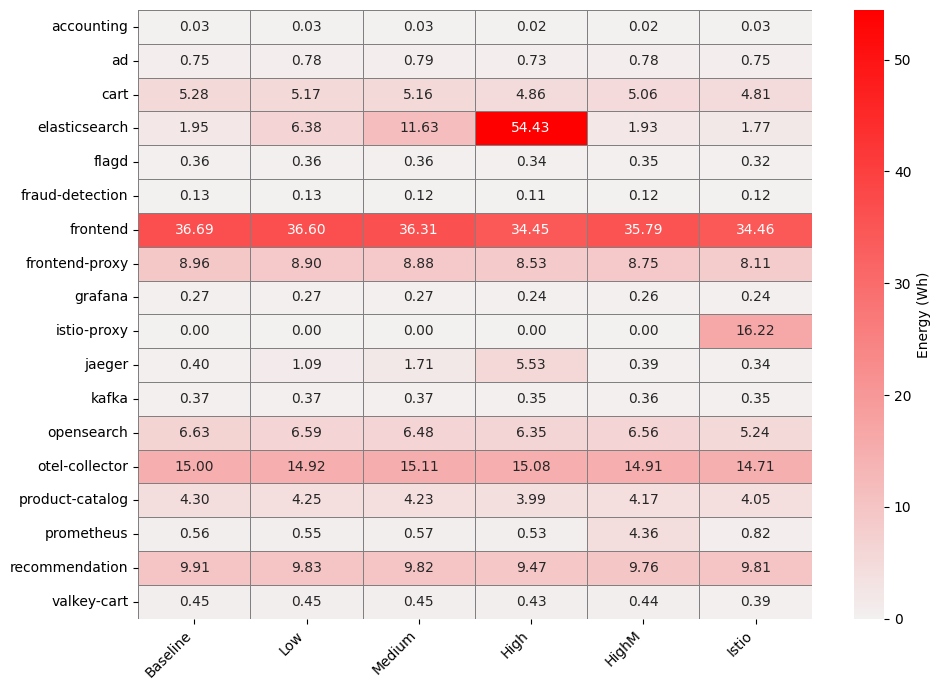

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------
# 1  Prepare the numeric matrix (drop "Total" row and "Service Type" col)
# ------------------------------------------------------------------
df_plot = df.drop(index="Total").copy()

if isinstance(df_plot.columns, pd.MultiIndex):                       # you still have a 2‑level header
    # remove the column whose *second‑level* label is "Service Type"
    df_plot = df_plot.drop(columns=[c for c in df_plot.columns
                                    if c[1] == "Service Type"])
    df_plot.columns = df_plot.columns.get_level_values(1)            # keep only the experiment names
else:
    df_plot = df_plot.drop(columns="Service Type")

df_plot = df_plot.astype(float)      # make sure everything is numeric

# ------------------------------------------------------------------
# 2  Plot the heat‑map
# ------------------------------------------------------------------
plt.figure(figsize=(10, 7))
ax = sns.heatmap(
    df_plot,
    cmap=sns.light_palette("red", as_cmap=True),  # white → red
    annot=True, fmt=".2f",                        # write raw Wh inside the cells
    linewidths=0.4, linecolor="grey",
    cbar_kws={"label": "Energy (Wh)"}
)

ax.set_xlabel("")
ax.set_ylabel("")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


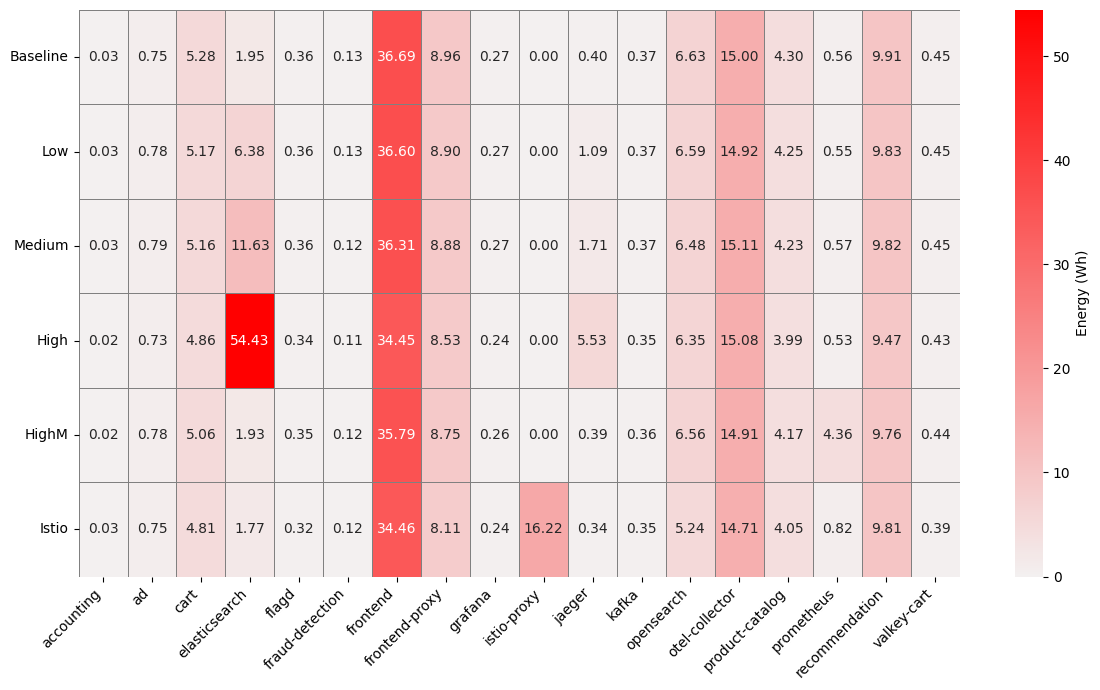

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------
# 1  Prepare the numeric matrix
# ------------------------------------------------------------------
df_plot = df.drop(index="Total").copy()

# Remove the “Service Type” text column and flatten the header
if isinstance(df_plot.columns, pd.MultiIndex):
    df_plot = df_plot.drop(
        columns=[c for c in df_plot.columns if c[1] == "Service Type"]
    )
    df_plot.columns = df_plot.columns.get_level_values(1)
else:
    df_plot = df_plot.drop(columns="Service Type")

df_plot = df_plot.astype(float)

# ------------------------------------------------------------------
# 2  Transpose so experiments are rows, services are columns
# ------------------------------------------------------------------
heat_data = df_plot.T

# ------------------------------------------------------------------
# 3  Plot the heat‑map
# ------------------------------------------------------------------
plt.figure(figsize=(12, 7))
ax = sns.heatmap(
    heat_data,
    cmap=sns.light_palette("red", as_cmap=True),  # white → red
    annot=True, fmt=".2f",
    linewidths=0.4, linecolor="grey",
    cbar_kws={"label": "Energy (Wh)"}
)

ax.set_xlabel("")               # tidy up axis titles
ax.set_ylabel("")
plt.yticks(rotation=0)          # keep experiment names horizontal
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
